In [1]:
import numpy as np
import tensorflow as tf
import strawberryfields as sf
from strawberryfields import ops
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
def interferometer(params, q):
    """Parameterised interferometer acting on ``N`` modes.

    Args:
        params (list[float]): list of length ``max(1, N-1) + (N-1)*N`` parameters.

            * The first ``N(N-1)/2`` parameters correspond to the beamsplitter angles
            * The second ``N(N-1)/2`` parameters correspond to the beamsplitter phases
            * The final ``N-1`` parameters correspond to local rotation on the first N-1 modes

        q (list[RegRef]): list of Strawberry Fields quantum registers the interferometer
            is to be applied to
    """
    N = len(q)
    theta = params[:N*(N-1)//2]
    phi = params[N*(N-1)//2:N*(N-1)]
    rphi = params[-N+1:]

    if N == 1:
        # the interferometer is a single rotation
        ops.Rgate(rphi[0]) | q[0]
        return

    n = 0  # keep track of free parameters

    # Apply the rectangular beamsplitter array
    # The array depth is N
    for l in range(N):
        for k, (q1, q2) in enumerate(zip(q[:-1], q[1:])):
            # skip even or odd pairs depending on layer
            if (l + k) % 2 != 1:
                ops.BSgate(theta[n], phi[n]) | (q1, q2)
                n += 1

    # apply the final local phase shifts to all modes except the last one
    for i in range(max(1, N - 1)):
        ops.Rgate(rphi[i]) | q[i]

In [3]:
def layer(params, q):
    """CV quantum neural network layer acting on ``N`` modes.

    Args:
        params (list[float]): list of length ``2*(max(1, N-1) + N**2 + n)`` containing
            the number of parameters for the layer
        q (list[RegRef]): list of Strawberry Fields quantum registers the layer
            is to be applied to
    """
    N = len(q)
    M = int(N * (N - 1)) + max(1, N - 1)

    int1 = params[:M]
    s = params[M:M+N]
    int2 = params[M+N:2*M+N]
    dr = params[2*M+N:2*M+2*N]
    dp = params[2*M+2*N:2*M+3*N]
    k = params[2*M+3*N:2*M+4*N]

    # begin layer
    interferometer(int1, q)

    for i in range(N):
        ops.Sgate(s[i]) | q[i]

    interferometer(int2, q)

    for i in range(N):
        ops.Dgate(dr[i], dp[i]) | q[i]
        ops.Kgate(k[i]) | q[i]

In [4]:
def init_weights(modes, layers, active_sd=0.0001, passive_sd=0.1):
    """Initialize a 2D TensorFlow Variable containing normally-distributed
    random weights for an ``N`` mode quantum neural network with ``L`` layers.

    Args:
        modes (int): the number of modes in the quantum neural network
        layers (int): the number of layers in the quantum neural network
        active_sd (float): the standard deviation used when initializing
            the normally-distributed weights for the active parameters
            (displacement, squeezing, and Kerr magnitude)
        passive_sd (float): the standard deviation used when initializing
            the normally-distributed weights for the passive parameters
            (beamsplitter angles and all gate phases)

    Returns:
        tf.Variable[tf.float32]: A TensorFlow Variable of shape
        ``[layers, 2*(max(1, modes-1) + modes**2 + modes)]``, where the Lth
        row represents the layer parameters for the Lth layer.
    """
    # Number of interferometer parameters:
    M = int(modes * (modes - 1)) + max(1, modes - 1)

    # Create the TensorFlow variables
    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    dp_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat(
        [int1_weights, s_weights, int2_weights, dr_weights, dp_weights, k_weights], axis=1
    )

    weights = tf.Variable(weights)

    return weights

In [5]:
# set the random seed
tf.random.set_seed(137)
np.random.seed(137)


# define width and depth of CV quantum neural network
modes = 2
layers = 8
cutoff_dim = 6

In [6]:
# initialize engine and program
eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": cutoff_dim})
qnn = sf.Program(modes)

# initialize QNN weights
weights = init_weights(modes, layers) # our TensorFlow weights
num_params = np.prod(weights.shape)   # total number of parameters in our model

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-16 15:14:36.412420: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-16 15:14:36.412521: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
print(qnn)

Program(None, 2->2 subsystems, compiled for 'None')


In [8]:
# Create array of Strawberry Fields symbolic gate arguments, matching
# the size of the weights Variable.
sf_params = np.arange(num_params).reshape(weights.shape).astype(np.str)
sf_params = np.array([qnn.params(*i) for i in sf_params])


# Construct the symbolic Strawberry Fields program by
# looping and applying layers to the program.
with qnn.context as q:
    for k in range(layers):
        layer(sf_params[k], q)

/var/folders/7j/z471krp14yq8nlbjn0hnpmp4y7whw6/T/ipykernel_3320/1819069251.py:3: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [9]:
def cost(weights):
    # Create a dictionary mapping from the names of the Strawberry Fields
    # symbolic gate parameters to the TensorFlow weight values.
    mapping = {p.name: w for p, w in zip(sf_params.flatten(), tf.reshape(weights, [-1]))}

    state = eng.run(qnn, args=mapping).state

    x = tf.reshape(tf.stack([state.quad_expectation(mode=i, phi=0.0)[0] for i in range(modes)]), shape=(modes, 1))
    p = tf.reshape(tf.stack([state.quad_expectation(mode=i, phi=0.5*np.pi)[0] for i in range(modes)]), shape=(modes, 1))

    gamma = tf.Variable(np.ones(shape=(modes, modes)) - np.eye(modes), dtype=tf.float32)
    H = 0.5 * tf.reduce_sum(x**2 + p**2) + 0.25 * tf.matmul(tf.transpose(x), tf.matmul(gamma, x))
    return H[0][0], state

In [15]:
opt = tf.keras.optimizers.Adam()
cost_before = cost(weights)
loss_history = []

for i in range(100):
    # reset the engine if it has already been executed
    if eng.run_progs:
        eng.reset()

    with tf.GradientTape() as tape:
        loss, state = cost(weights)

    loss_history.append(loss)

    gradients = tape.gradient(loss, weights)
    opt.apply_gradients(zip([gradients], [weights]))

    if i % 1 == 0:
        print("Rep: {} Cost: {:.20f}".format(i, loss))

Rep: 0 Cost: 0.00008652138058096170
Rep: 1 Cost: 0.00007703171286266297
Rep: 2 Cost: 0.00006973082781769335
Rep: 3 Cost: 0.00000346621209246223
Rep: 4 Cost: 0.00002127488005498890
Rep: 5 Cost: 0.00004991672176402062
Rep: 6 Cost: 0.00002836327257682569
Rep: 7 Cost: 0.00000180798906512791
Rep: 8 Cost: 0.00000768039535614662
Rep: 9 Cost: 0.00002601770756882615
Rep: 10 Cost: 0.00002417868563497905
Rep: 11 Cost: 0.00000752686264604563
Rep: 12 Cost: 0.00000011156064516626
Rep: 13 Cost: 0.00000838911546452437
Rep: 14 Cost: 0.00001646654891374055
Rep: 15 Cost: 0.00001227069697051775
Rep: 16 Cost: 0.00000276012951871962
Rep: 17 Cost: 0.00000042747331008286
Rep: 18 Cost: 0.00000612459507465246
Rep: 19 Cost: 0.00001000372867565602
Rep: 20 Cost: 0.00000656516886010650
Rep: 21 Cost: 0.00000107226708223607
Rep: 22 Cost: 0.00000056957765082188
Rep: 23 Cost: 0.00000432103115599602
Rep: 24 Cost: 0.00000605727655056398
Rep: 25 Cost: 0.00000337613755618804
Rep: 26 Cost: 0.00000029721411465289
Rep: 27 Cos

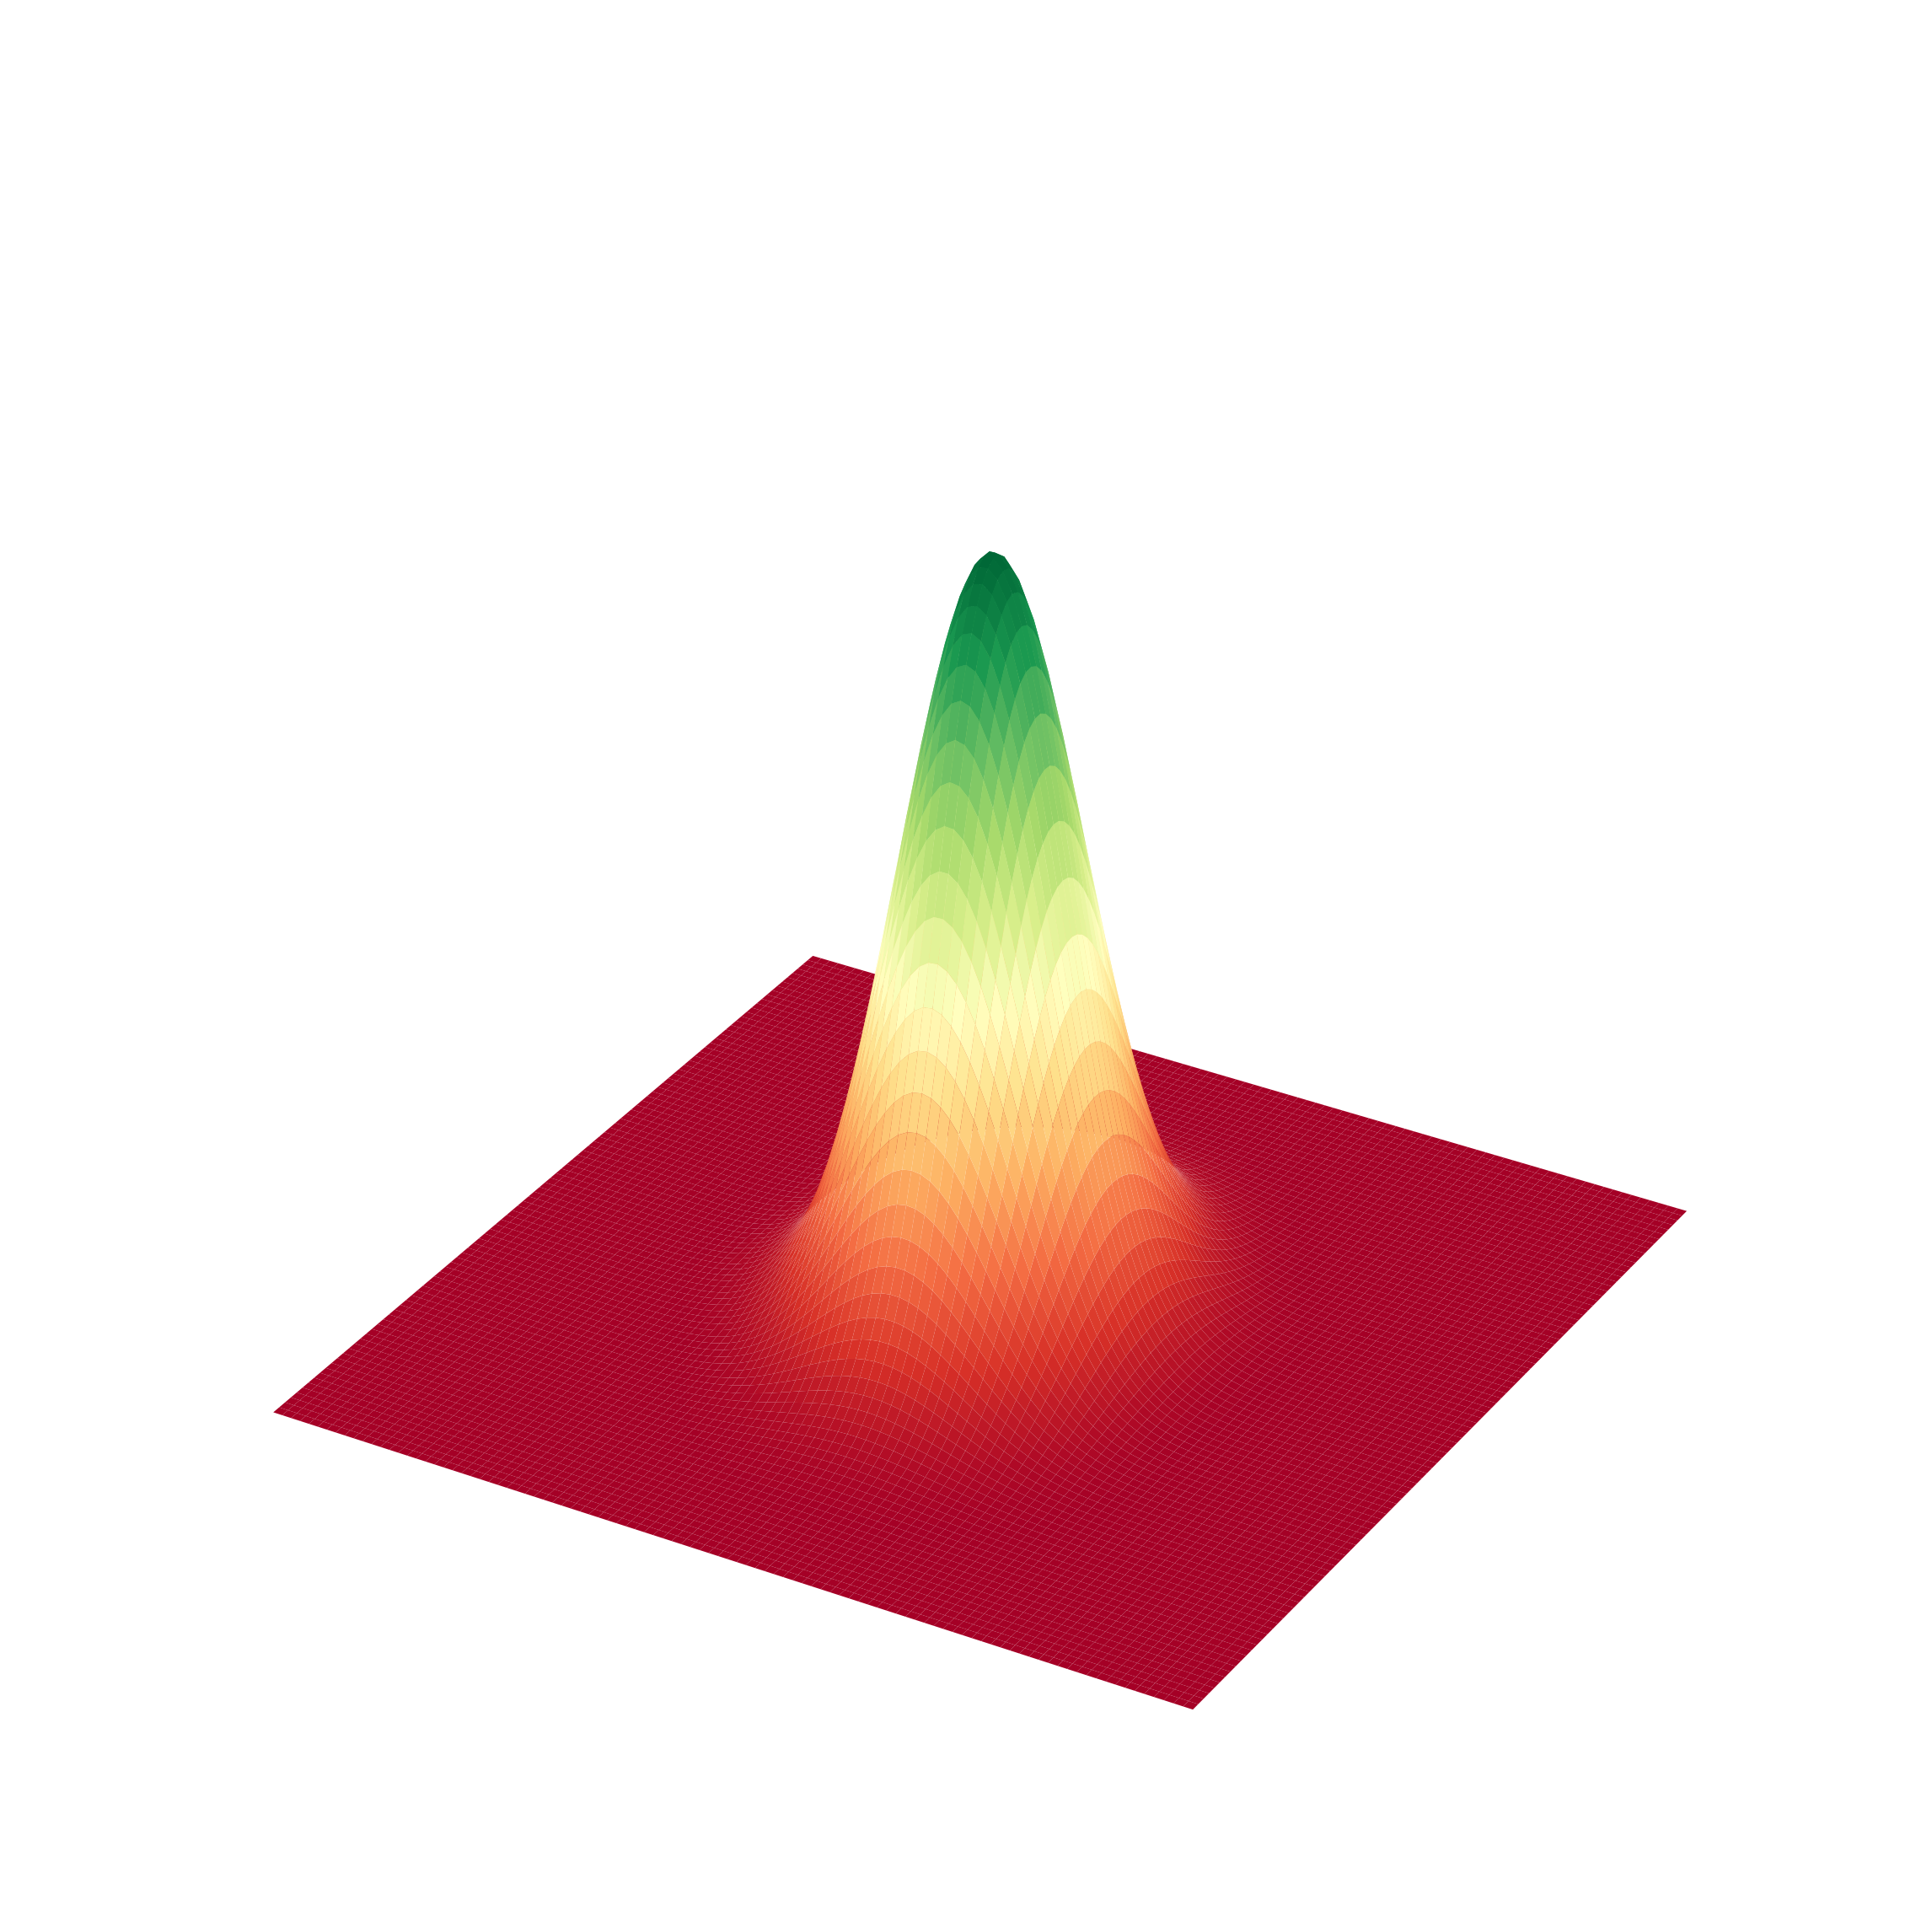

In [16]:
fig = plt.figure()
X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state.wigner(0, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
fig.set_size_inches(4.8, 5)
ax.set_axis_off()

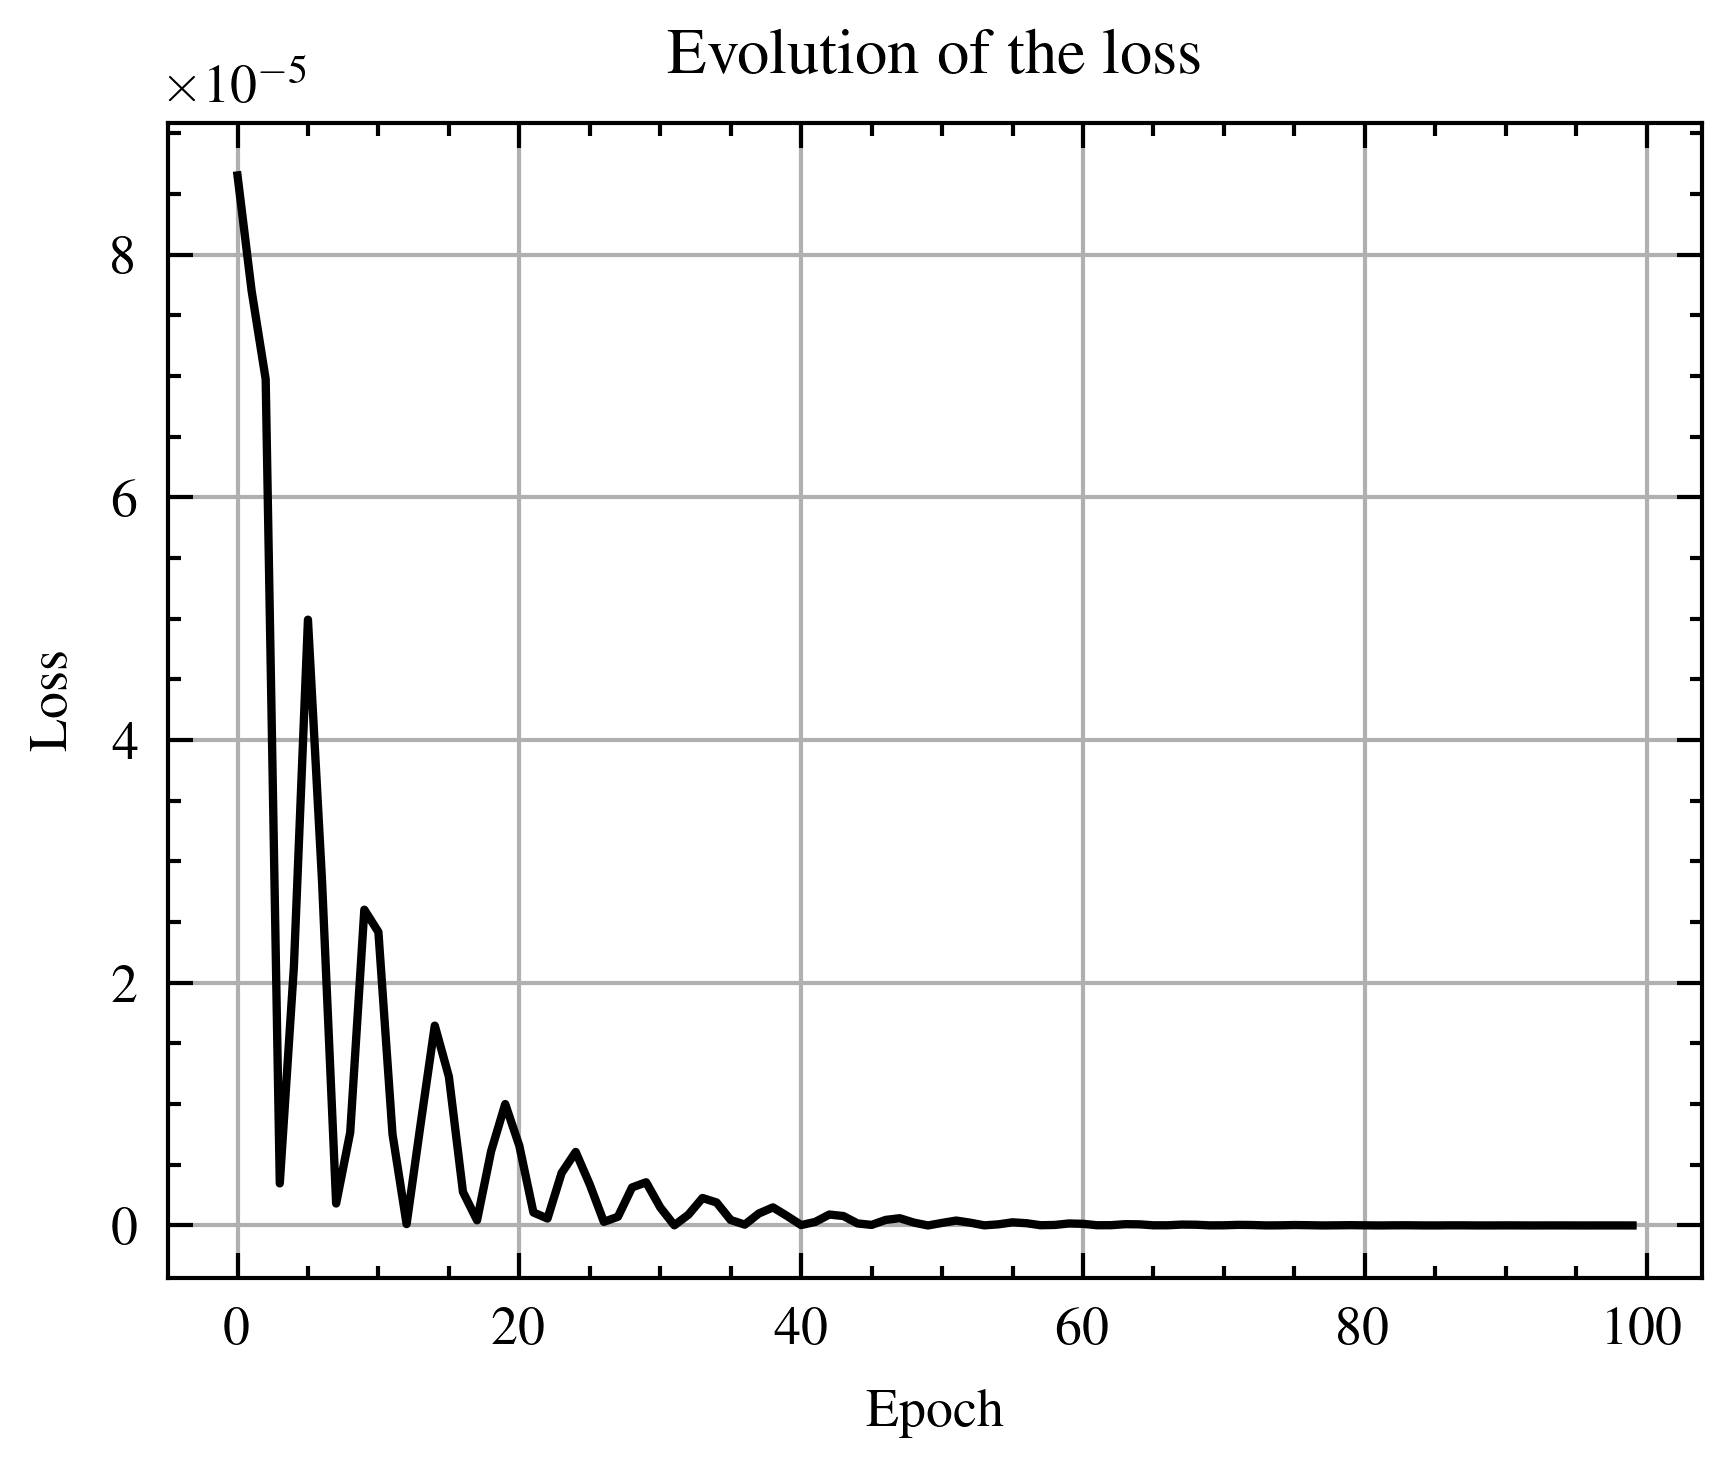

In [17]:
plt.style.use('./src/plots.mplstyle')
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(loss_history)
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')
axes.grid(True)
axes.set_title('Evolution of the loss')
plt.savefig('./a.png', dpi=300, transparent=False, bbox_inches='tight')